In [17]:
import model
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt




## Prepare data

In [18]:
### Prepare data

cordata = pd.read_csv("cordata.csv")
macro = pd.read_csv("disaggregated.csv")
dummy = pd.read_csv("dummy.csv")

macro = macro.rename(columns = {"Unnamed: 3": "Date"})
features = pd.merge(macro, dummy, on="Date")

target = cordata[["Date", "BIR", "BOC", "Other Offices", "Non-tax Revenues", "Expenditures"]]
features = features[["Date", "Inflation", "Imports", "Exports", "USDPHP", "NominalGDP_disagg", "Pop_disagg", 
                     "COVID-19", "TRAIN","CREATE","FIST","BIR_COMM"]]
# features = features[["Date", "Inflation", "Imports", "Exports", "USDPHP", "NominalGDP_disagg", "Pop_disagg", 
#                      "COVID-19"]]

# Convert Date to datetime
target["Date"] = pd.to_datetime(target["Date"])
features["Date"] = pd.to_datetime(features["Date"])

# Filter both to start from 1992-01-01
target = target[target["Date"] >= "1992-01-01"]
features = features[features["Date"] >= "1992-01-01"]

target = target.set_index("Date")
features = features.set_index("Date")

# Replace NaN values with 0
features = features.fillna(0)

C:\Users\Jojie\AppData\Local\Temp\ipykernel_61768\3659050456.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target["Date"] = pd.to_datetime(target["Date"])


In [20]:
### Add lag features
# Create lag-1 features from target variables
lag_features = target.shift(1)

# Rename lag columns
lag_features.columns = [f"{col}_lag1" for col in lag_features.columns]

# Merge lag features with features
features = pd.concat([features, lag_features], axis=1)

# Drop rows with NaN (first row will have NaN for lag features)
features = features.dropna()
target = target.loc[features.index]

print(f"Features shape after adding lag-1: {features.shape}")
print(f"Target shape after alignment: {target.shape}")
print(f"New features:\n{features.columns.tolist()}")

Features shape after adding lag-1: (393, 16)
Target shape after alignment: (393, 5)
New features:
['Inflation', 'Imports', 'Exports', 'USDPHP', 'NominalGDP_disagg', 'Pop_disagg', 'COVID-19', 'TRAIN', 'CREATE', 'FIST', 'BIR_COMM', 'BIR_lag1', 'BOC_lag1', 'Other Offices_lag1', 'Non-tax Revenues_lag1', 'Expenditures_lag1']


In [21]:
### Data split
train_size = 0.7
val_size = 0.15
test_size = 0.15

# First split: 70% train, 30% temp (which will be split into val and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    features, target, test_size=(val_size + test_size), random_state=42, shuffle=False)

# Second split: split the temp set into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

print("Data Split Summary:")
print(f"Train set: {X_train.shape[0]} samples ({train_size*100:.0f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({val_size*100:.0f}%)")
print(f"Test set: {X_test.shape[0]} samples ({test_size*100:.0f}%)")
print(f"\nTrain date range: {y_train.index[0].date()} to {y_train.index[-1].date()}")
print(f"Validation date range: {y_val.index[0].date()} to {y_val.index[-1].date()}")
print(f"Test date range: {y_test.index[0].date()} to {y_test.index[-1].date()}")

Data Split Summary:
Train set: 275 samples (70%)
Validation set: 59 samples (15%)
Test set: 59 samples (15%)

Train date range: 1992-02-01 to 2015-02-01
Validation date range: 2015-03-01 to 2020-01-01
Test date range: 2020-02-01 to 2024-12-01


In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((275, 16), (59, 16), (275, 5), (59, 5))

#Apply transformations

In [23]:
# Apply MinMaxScaler to X_train and y_train
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform X_train
X_train_scaled = scaler_X.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

# Fit and transform y_train
y_train_scaled = scaler_y.fit_transform(y_train)
y_train_scaled = pd.DataFrame(y_train_scaled, columns=y_train.columns, index=y_train.index)

# Transform X_test and y_test using the fitted scalers
X_val_scaled = scaler_X.transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)

y_val_scaled = scaler_y.transform(y_val)
y_val_scaled = pd.DataFrame(y_val_scaled, columns=y_val.columns, index=y_val.index)

# Transform X_test and y_test using the fitted scalers
X_test_scaled = scaler_X.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

y_test_scaled = scaler_y.transform(y_test)
y_test_scaled = pd.DataFrame(y_test_scaled, columns=y_test.columns, index=y_test.index)

In [24]:
### Create sequences from split data
def create_sequences_from_arrays(X_array, y_array, seq_length):
    """
    Create sequences of data for time series modeling.
    
    Args:
        X_array: numpy array of features
        y_array: numpy array of targets
        seq_length: length of sequence
    
    Returns:
        X_seq: sequences of shape (n_samples, seq_length, n_features)
        y_seq: target values corresponding to sequences
    """
    X_seq = []
    y_seq = []
    
    for i in range(len(X_array) - seq_length):
        X_seq.append(X_array[i:i+seq_length])
        y_seq.append(y_array[i+seq_length])
    
    return np.array(X_seq), np.array(y_seq)

# Define sequence length
sequence_length = 12

print(f"Creating sequences with length: {sequence_length}")
print(f"Before sequences - X_train shape: {X_train_scaled.shape}")

# Create sequences from SCALED split data
X_train_seq, y_train_seq = create_sequences_from_arrays(X_train_scaled.values, y_train_scaled.values, sequence_length)
X_val_seq, y_val_seq = create_sequences_from_arrays(X_val_scaled.values, y_val_scaled.values, sequence_length)
X_test_seq, y_test_seq = create_sequences_from_arrays(X_test_scaled.values, y_test_scaled.values, sequence_length)

print(f"\nAfter sequences:")
print(f"X_train_seq shape: {X_train_seq.shape} (n_samples, seq_length, n_features)")
print(f"y_train_seq shape: {y_train_seq.shape}")
print(f"X_val_seq shape: {X_val_seq.shape}")
print(f"y_val_seq shape: {y_val_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}")
print(f"y_test_seq shape: {y_test_seq.shape}")

# Store test indices for later (accounting for sequence_length offset)
test_indices = y_test.index[sequence_length:]
print(f"\nTest indices after sequence offset: {len(test_indices)} samples")

Creating sequences with length: 12
Before sequences - X_train shape: (275, 16)

After sequences:
X_train_seq shape: (263, 12, 16) (n_samples, seq_length, n_features)
y_train_seq shape: (263, 5)
X_val_seq shape: (47, 12, 16)
y_val_seq shape: (47, 5)
X_test_seq shape: (47, 12, 16)
y_test_seq shape: (47, 5)

Test indices after sequence offset: 47 samples


#Load to dataloader

In [25]:
# Convert sequence data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_seq)  # Shape: (n_samples, seq_length, n_features)
y_train_tensor = torch.FloatTensor(y_train_seq)

X_val_tensor = torch.FloatTensor(X_val_seq)
y_val_tensor = torch.FloatTensor(y_val_seq)

X_test_tensor = torch.FloatTensor(X_test_seq)
y_test_tensor = torch.FloatTensor(y_test_seq)

print(f"Tensor shapes:")
print(f"X_train_tensor: {X_train_tensor.shape}")
print(f"y_train_tensor: {y_train_tensor.shape}")

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Tensor shapes:
X_train_tensor: torch.Size([263, 12, 16])
y_train_tensor: torch.Size([263, 5])


## Train Model

In [27]:
### Train model

# Check for NaN values in data
print(f"NaN in X_train_tensor: {torch.isnan(X_train_tensor).any()}")
print(f"NaN in y_train_tensor: {torch.isnan(y_train_tensor).any()}")
print(f"X_train_tensor range: [{X_train_tensor.min():.4f}, {X_train_tensor.max():.4f}]")
print(f"y_train_tensor range: [{y_train_tensor.min():.4f}, {y_train_tensor.max():.4f}]")

# Determine device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model parameters
input_size = X_train_tensor.shape[2]  # Number of features (now at dimension 2)
num_channels = [64, 64, 64]
output_size = y_train_tensor.shape[1]  # Number of target variables
kernel_size = 4
dropout = 0.2

print(f"\nModel Configuration:")
print(f"Input size (features): {input_size}")
print(f"Sequence length: {X_train_tensor.shape[1]}")
print(f"Output size (targets): {output_size}")

# Initialize model
tcn_model = model.TCNRegressor(
    input_size=input_size,
    num_channels=num_channels,
    output_size=output_size,
    kernel_size=kernel_size,
    dropout=dropout
).to(device)

# Loss function and optimizer
criterion = nn.L1Loss()  # Better for volatile data like revenue
optimizer = torch.optim.Adam(tcn_model.parameters(), lr=0.0005)  

# Training loop
epochs = 100
train_losses = []
val_losses = []
max_grad_norm = 1.0  # Gradient clipping threshold

print("Starting training...")
for epoch in range(epochs):
    # Training phase
    tcn_model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # X_batch already has shape (batch, seq_length, n_features)
        # TCN expects (batch, n_features, seq_length), so transpose
        X_batch = X_batch.transpose(1, 2)
        
        # Forward pass
        optimizer.zero_grad()
        predictions = tcn_model(X_batch)
        loss = criterion(predictions, y_batch)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(tcn_model.parameters(), max_grad_norm)
        
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    tcn_model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            X_batch = X_batch.transpose(1, 2)
            
            predictions = tcn_model(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

print("Training completed!")
print(f"Final Train Loss: {train_losses[-1]:.6f}")
print(f"Final Val Loss: {val_losses[-1]:.6f}")

NaN in X_train_tensor: False
NaN in y_train_tensor: False
X_train_tensor range: [0.0000, 1.0000]
y_train_tensor range: [0.0000, 1.0000]
Using device: cpu

Model Configuration:
Input size (features): 16
Sequence length: 12
Output size (targets): 5
Starting training...
Epoch 10/100 - Train Loss: 0.058852, Val Loss: 0.187008
Epoch 20/100 - Train Loss: 0.054981, Val Loss: 0.245564
Epoch 30/100 - Train Loss: 0.051926, Val Loss: 0.211237
Epoch 40/100 - Train Loss: 0.047510, Val Loss: 0.185449
Epoch 50/100 - Train Loss: 0.047990, Val Loss: 0.184069
Epoch 60/100 - Train Loss: 0.044375, Val Loss: 0.178579
Epoch 70/100 - Train Loss: 0.042842, Val Loss: 0.203986
Epoch 80/100 - Train Loss: 0.041547, Val Loss: 0.193464
Epoch 90/100 - Train Loss: 0.040534, Val Loss: 0.169814
Epoch 100/100 - Train Loss: 0.038789, Val Loss: 0.167464
Training completed!
Final Train Loss: 0.038789
Final Val Loss: 0.167464


## Predictions

In [29]:
# Make predictions on test set
tcn_model.eval()
all_predictions = []
all_actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        X_batch = X_batch.transpose(1, 2)  # (batch, n_features, seq_length)
        
        predictions = tcn_model(X_batch)
        all_predictions.append(predictions.cpu().numpy())
        all_actuals.append(y_batch.cpu().numpy())

# Concatenate all predictions and actuals
predictions_scaled = np.vstack(all_predictions)
actuals_scaled = np.vstack(all_actuals)

# Inverse transform to get original scale
predictions_original = scaler_y.inverse_transform(predictions_scaled)
actuals_original = scaler_y.inverse_transform(actuals_scaled)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(actuals_original, predictions_original))
mae = mean_absolute_error(actuals_original, predictions_original)

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((actuals_original - predictions_original) / actuals_original)) * 100

print("=== Model Performance Metrics ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")

# Get predictions for dates
print("\n=== Predictions ===")
print(f"Test set has {len(test_indices)} predictions (after sequence offset)")
print(f"Date range: {test_indices[0].date()} to {test_indices[-1].date()}")

# Create results dataframe with proper index alignment
results_df = pd.DataFrame(index=test_indices)
for i, col in enumerate(y_test.columns):
    results_df[f"{col}_Actual"] = actuals_original[:, i]
    results_df[f"{col}_Predicted"] = predictions_original[:, i]

print(f"\nResults shape: {results_df.shape}")
print("\nLast 10 rows of predictions:")
print(results_df.tail(10))

=== Model Performance Metrics ===
RMSE: 63144.4941
MAE: 36061.3867
MAPE: 27.8074%

=== Predictions ===
Test set has 47 predictions (after sequence offset)
Date range: 2021-02-01 to 2024-12-01

Results shape: (47, 10)

Last 10 rows of predictions:
              BIR_Actual  BIR_Predicted    BOC_Actual  BOC_Predicted  \
Date                                                                   
2024-03-01  145346.00000  211270.484375  74895.000000   59606.082031   
2024-04-01  378521.00000  287121.093750  80742.007812   58299.527344   
2024-05-01  219228.00000  238220.437500  81301.007812   57418.031250   
2024-06-01  172503.00000  208707.140625  74623.000000   57435.726562   
2024-07-01  319814.00000  233424.609375  80355.000000   59638.203125   
2024-08-01  238120.00000  216513.500000  78521.000000   55406.078125   
2024-09-01  174679.00000  211731.390625  76282.000000   59303.695312   
2024-10-01  325535.96875  242030.531250  86885.000000   61289.066406   
2024-11-01  247594.00000  255834.

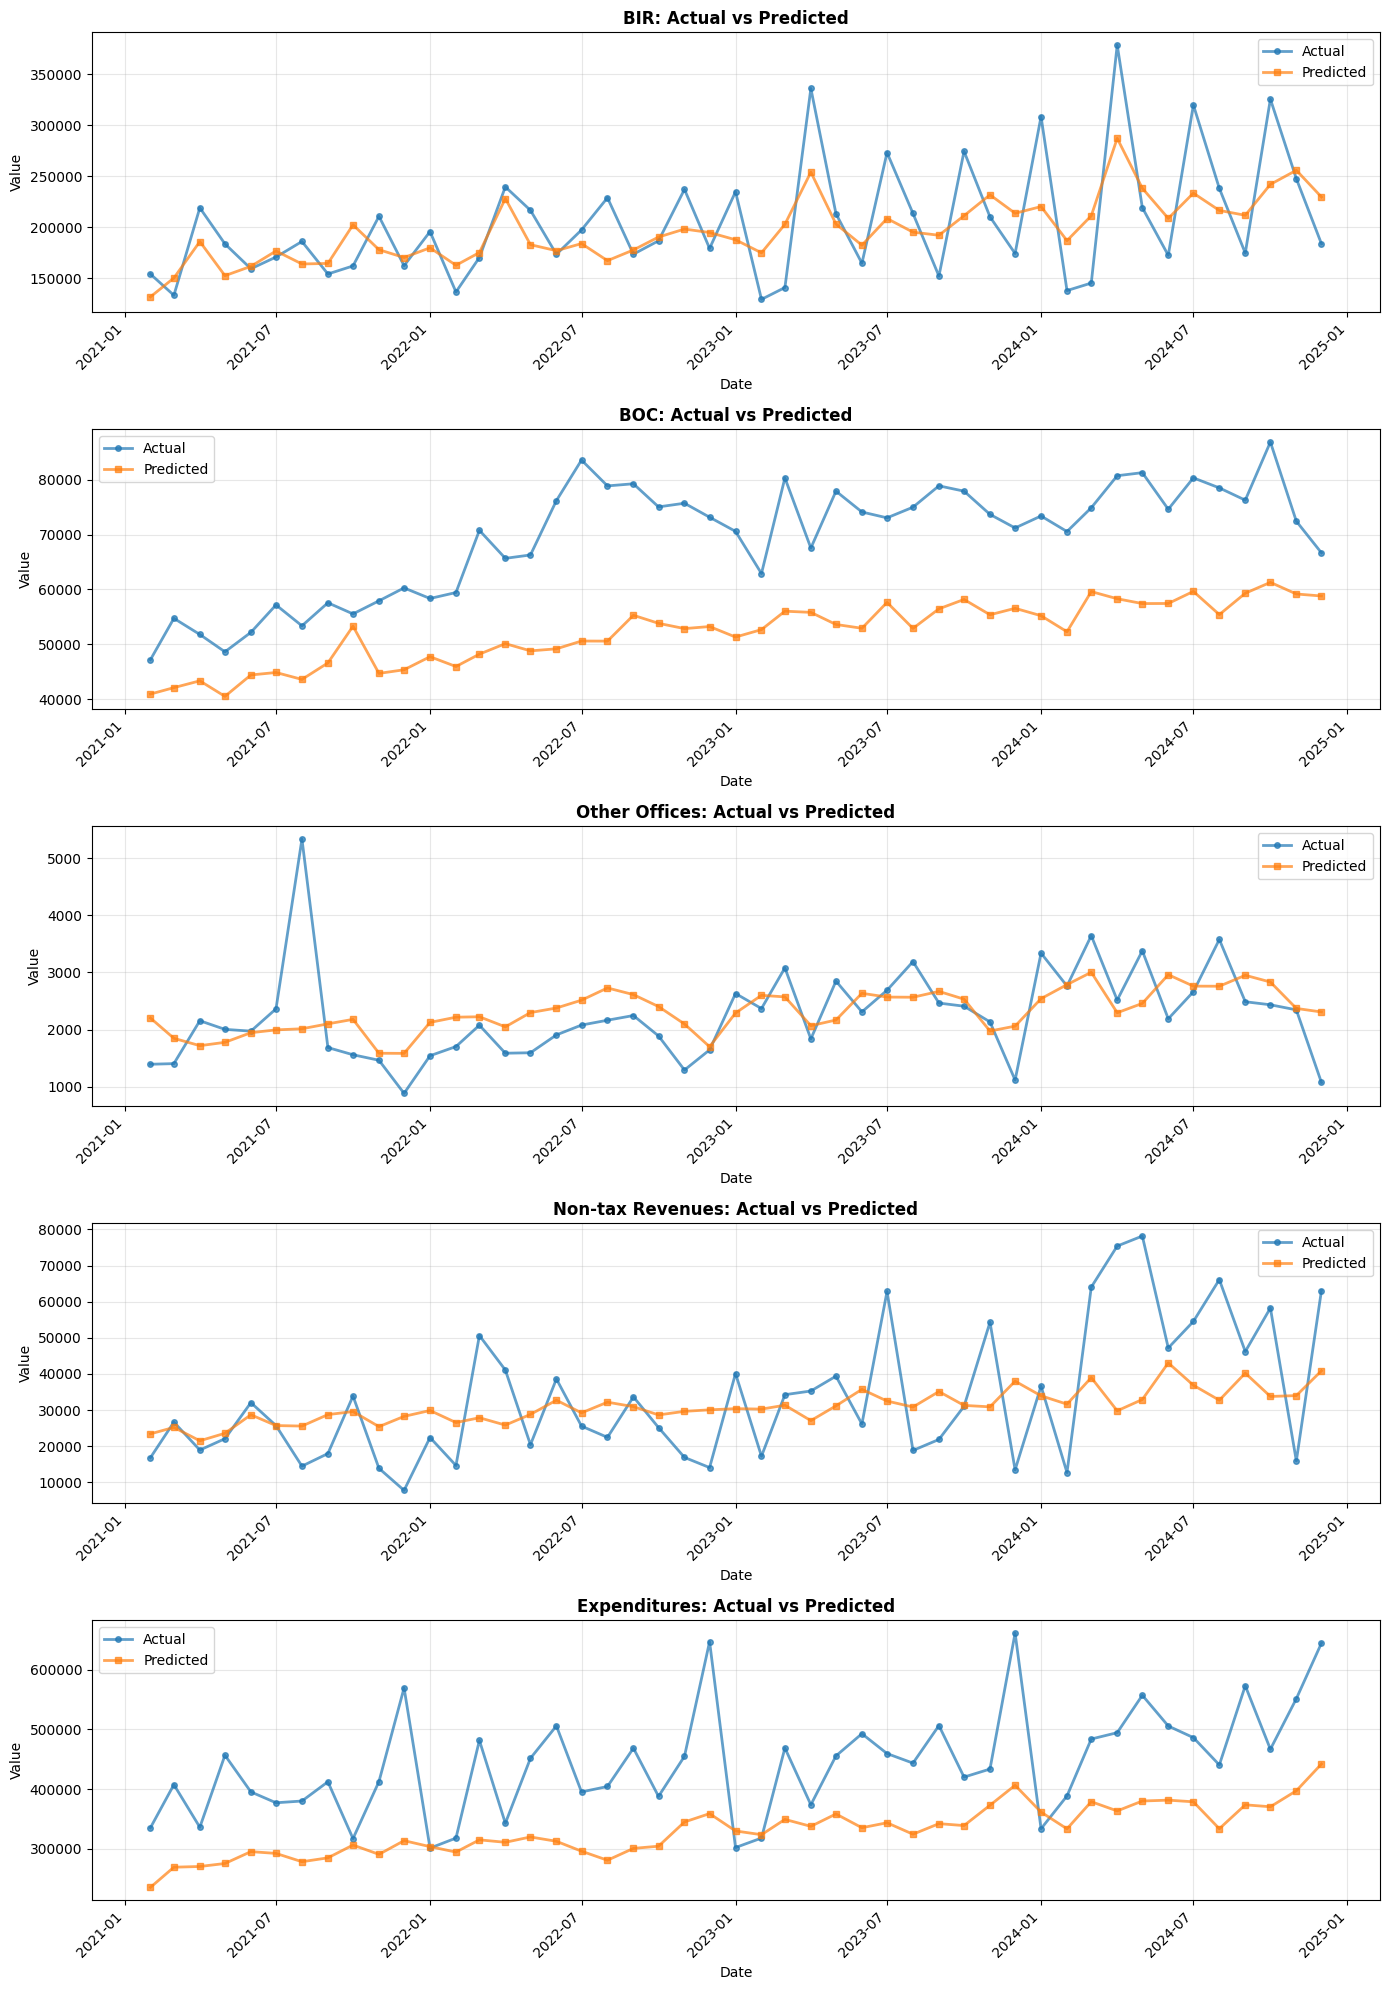

Graph saved as 'tcn_predictions_comparison.png'

=== Per-Variable Performance Metrics ===

BIR:
  RMSE: 42425.5908
  MAE: 34074.2422
  MAPE: 16.4140%

BOC:
  RMSE: 18405.9564
  MAE: 17224.3770
  MAPE: 24.1274%

Other Offices:
  RMSE: 713.5669
  MAE: 510.5629
  MAPE: 25.3159%

Non-tax Revenues:
  RMSE: 16877.3846
  MAE: 13035.2900
  MAPE: 48.7223%

Expenditures:
  RMSE: 132333.1669
  MAE: 115462.4609
  MAPE: 24.4574%


In [30]:
# Create comparison plots for each target variable
fig, axes = plt.subplots(len(y_test.columns), 1, figsize=(14, 4 * len(y_test.columns)))

# If only one target variable, axes is not an array
if len(y_test.columns) == 1:
    axes = [axes]

for i, col in enumerate(y_test.columns):
    ax = axes[i]
    
    # Plot actual vs predicted
    ax.plot(results_df.index, results_df[f"{col}_Actual"], 
            label='Actual', linewidth=2, marker='o', markersize=4, alpha=0.7)
    ax.plot(results_df.index, results_df[f"{col}_Predicted"], 
            label='Predicted', linewidth=2, marker='s', markersize=4, alpha=0.7)
    
    # Formatting
    ax.set_title(f'{col}: Actual vs Predicted', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Value', fontsize=10)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('tcn_predictions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Graph saved as 'tcn_predictions_comparison.png'")

# Calculate per-variable metrics
print("\n=== Per-Variable Performance Metrics ===")
for i, col in enumerate(y_test.columns):
    actual = actuals_original[:, i]
    predicted = predictions_original[:, i]
    
    rmse_var = np.sqrt(mean_squared_error(actual, predicted))
    mae_var = mean_absolute_error(actual, predicted)
    mape_var = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    print(f"\n{col}:")
    print(f"  RMSE: {rmse_var:.4f}")
    print(f"  MAE: {mae_var:.4f}")
    print(f"  MAPE: {mape_var:.4f}%")

## Trial With Cross Validation

In [31]:
### Time Series Cross-Validation (Walk-Forward)

def create_sequences_from_arrays(X_array, y_array, seq_length):
    """Create sequences for time series."""
    X_seq = []
    y_seq = []
    for i in range(len(X_array) - seq_length):
        X_seq.append(X_array[i:i+seq_length])
        y_seq.append(y_array[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

def time_series_cross_validation(X, y, n_splits=5, sequence_length=7, test_size=0.2):
    """
    Time series cross-validation (Walk-Forward).
    Splits data chronologically into multiple train/test pairs.
    
    Args:
        X, y: Full dataset
        n_splits: Number of CV folds
        sequence_length: Length of sequences
        test_size: Fraction of data to use as test in each fold
    
    Yields:
        X_train_seq, y_train_seq, X_test_seq, y_test_seq, test_indices for each fold
    """
    n_samples = len(X)
    fold_size = n_samples // (n_splits + 1)
    
    for fold in range(n_splits):
        # Calculate split point: gradually move forward
        train_end = fold_size * (fold + 1)
        test_end = min(train_end + fold_size, n_samples)
        
        # Split data chronologically
        X_train_fold = X[:train_end]
        y_train_fold = y[:train_end]
        X_test_fold = X[train_end:test_end]
        y_test_fold = y[train_end:test_end]
        
        # Scale each fold independently (fit on train only)
        scaler_X_fold = MinMaxScaler()
        scaler_y_fold = MinMaxScaler()
        
        X_train_scaled_fold = scaler_X_fold.fit_transform(X_train_fold)
        y_train_scaled_fold = scaler_y_fold.fit_transform(y_train_fold)
        X_test_scaled_fold = scaler_X_fold.transform(X_test_fold)
        y_test_scaled_fold = scaler_y_fold.transform(y_test_fold)
        
        # Create sequences
        X_train_seq_fold, y_train_seq_fold = create_sequences_from_arrays(
            X_train_scaled_fold, y_train_scaled_fold, sequence_length)
        X_test_seq_fold, y_test_seq_fold = create_sequences_from_arrays(
            X_test_scaled_fold, y_test_scaled_fold, sequence_length)
        
        # Store test indices
        test_indices_fold = y.index[train_end + sequence_length:test_end]
        
        print(f"\n=== Fold {fold+1}/{n_splits} ===")
        print(f"Train: {len(X_train_fold)} samples, Test: {len(X_test_fold)} samples")
        print(f"Train sequences: {X_train_seq_fold.shape}, Test sequences: {X_test_seq_fold.shape}")
        
        yield X_train_seq_fold, y_train_seq_fold, X_test_seq_fold, y_test_seq_fold, test_indices_fold, scaler_y_fold

# Test the cross-validation generator
print("Time Series Cross-Validation Setup:")
print(f"Total samples: {len(features)}")
print(f"Number of folds: 5")
print(f"Sequence length: {sequence_length}\n")

cv_generator = time_series_cross_validation(features, target, n_splits=5, sequence_length=sequence_length)

# Store results from all folds
cv_results = []

for fold_idx, (X_train_cv, y_train_cv, X_test_cv, y_test_cv, test_idx_cv, scaler_cv) in enumerate(cv_generator):
    print(f"Fold {fold_idx+1} - Ready for training")
    cv_results.append({
        'fold': fold_idx + 1,
        'X_train_seq': X_train_cv,
        'y_train_seq': y_train_cv,
        'X_test_seq': X_test_cv,
        'y_test_seq': y_test_cv,
        'test_indices': test_idx_cv,
        'scaler_y': scaler_cv
    })

Time Series Cross-Validation Setup:
Total samples: 393
Number of folds: 5
Sequence length: 12


=== Fold 1/5 ===
Train: 65 samples, Test: 65 samples
Train sequences: (53, 12, 16), Test sequences: (53, 12, 16)
Fold 1 - Ready for training

=== Fold 2/5 ===
Train: 130 samples, Test: 65 samples
Train sequences: (118, 12, 16), Test sequences: (53, 12, 16)
Fold 2 - Ready for training

=== Fold 3/5 ===
Train: 195 samples, Test: 65 samples
Train sequences: (183, 12, 16), Test sequences: (53, 12, 16)
Fold 3 - Ready for training

=== Fold 4/5 ===
Train: 260 samples, Test: 65 samples
Train sequences: (248, 12, 16), Test sequences: (53, 12, 16)
Fold 4 - Ready for training

=== Fold 5/5 ===
Train: 325 samples, Test: 65 samples
Train sequences: (313, 12, 16), Test sequences: (53, 12, 16)
Fold 5 - Ready for training


In [33]:
### Train and Evaluate using Cross-Validation

cv_fold_metrics = []

for fold_data in cv_results:
    fold_num = fold_data['fold']
    X_train_cv = fold_data['X_train_seq']
    y_train_cv = fold_data['y_train_seq']
    X_test_cv = fold_data['X_test_seq']
    y_test_cv = fold_data['y_test_seq']
    test_idx_cv = fold_data['test_indices']
    scaler_y_cv = fold_data['scaler_y']
    
    print(f"\n{'='*60}")
    print(f"FOLD {fold_num}: Training TCN Model")
    print(f"{'='*60}")
    
    # Convert to tensors
    X_train_tensor_cv = torch.FloatTensor(X_train_cv)
    y_train_tensor_cv = torch.FloatTensor(y_train_cv)
    X_test_tensor_cv = torch.FloatTensor(X_test_cv)
    y_test_tensor_cv = torch.FloatTensor(y_test_cv)
    
    # Create datasets and loaders
    train_dataset_cv = TensorDataset(X_train_tensor_cv, y_train_tensor_cv)
    test_dataset_cv = TensorDataset(X_test_tensor_cv, y_test_tensor_cv)
    
    train_loader_cv = DataLoader(train_dataset_cv, batch_size=16, shuffle=False)
    test_loader_cv = DataLoader(test_dataset_cv, batch_size=16, shuffle=False)
    
    # Initialize model
    input_size_cv = X_train_tensor_cv.shape[2]
    output_size_cv = y_train_tensor_cv.shape[1]  # Get actual number of target variables
    
    print(f"Input size: {input_size_cv}, Output size: {output_size_cv}")
    
    tcn_model_cv = model.TCNRegressor(
        input_size=input_size_cv,
        num_channels=[64, 64, 64],
        output_size=output_size_cv,
        kernel_size=4,
        dropout=0.2
    ).to(device)
    
    criterion_cv = nn.L1Loss()
    optimizer_cv = torch.optim.Adam(tcn_model_cv.parameters(), lr=0.0005)
    
    # Train model
    epochs = 50  # Fewer epochs for CV
    train_losses_cv = []
    
    for epoch in range(epochs):
        tcn_model_cv.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader_cv:
            X_batch = X_batch.to(device).transpose(1, 2)
            y_batch = y_batch.to(device)
            
            optimizer_cv.zero_grad()
            predictions = tcn_model_cv(X_batch)
            loss = criterion_cv(predictions, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(tcn_model_cv.parameters(), 1.0)
            optimizer_cv.step()
            epoch_loss += loss.item()
        
        train_losses_cv.append(epoch_loss / len(train_loader_cv))
    
    # Test model
    tcn_model_cv.eval()
    all_pred_cv = []
    all_actual_cv = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader_cv:
            X_batch = X_batch.to(device).transpose(1, 2)
            predictions = tcn_model_cv(X_batch)
            all_pred_cv.append(predictions.cpu().numpy())
            all_actual_cv.append(y_batch.cpu().numpy())
    
    # Calculate metrics
    pred_scaled_cv = np.vstack(all_pred_cv)
    actual_scaled_cv = np.vstack(all_actual_cv)
    
    pred_original_cv = scaler_y_cv.inverse_transform(pred_scaled_cv)
    actual_original_cv = scaler_y_cv.inverse_transform(actual_scaled_cv)
    
    rmse_cv = np.sqrt(mean_squared_error(actual_original_cv, pred_original_cv))
    mae_cv = mean_absolute_error(actual_original_cv, pred_original_cv)
    mape_cv = np.mean(np.abs((actual_original_cv - pred_original_cv) / actual_original_cv)) * 100
    
    fold_metrics = {
        'fold': fold_num,
        'rmse': rmse_cv,
        'mae': mae_cv,
        'mape': mape_cv,
        'predictions': pred_original_cv,
        'actuals': actual_original_cv,
        'test_indices': test_idx_cv
    }
    cv_fold_metrics.append(fold_metrics)
    
    print(f"Fold {fold_num} Metrics:")
    print(f"  RMSE: {rmse_cv:.4f}")
    print(f"  MAE:  {mae_cv:.4f}")
    print(f"  MAPE: {mape_cv:.2f}%")

# Calculate average metrics across all folds
print(f"\n{'='*60}")
print("CROSS-VALIDATION SUMMARY")
print(f"{'='*60}")

avg_rmse = np.mean([m['rmse'] for m in cv_fold_metrics])
avg_mae = np.mean([m['mae'] for m in cv_fold_metrics])
avg_mape = np.mean([m['mape'] for m in cv_fold_metrics])

std_rmse = np.std([m['rmse'] for m in cv_fold_metrics])
std_mae = np.std([m['mae'] for m in cv_fold_metrics])
std_mape = np.std([m['mape'] for m in cv_fold_metrics])

print(f"\nAverage Performance (5 Folds):")
print(f"  RMSE: {avg_rmse:.4f} ± {std_rmse:.4f}")
print(f"  MAE:  {avg_mae:.4f} ± {std_mae:.4f}")
print(f"  MAPE: {avg_mape:.2f}% ± {std_mape:.2f}%")

print(f"\nPer-Fold Breakdown:")
for m in cv_fold_metrics:
    print(f"  Fold {m['fold']}: RMSE={m['rmse']:.4f}, MAE={m['mae']:.4f}, MAPE={m['mape']:.2f}%")


FOLD 1: Training TCN Model
Input size: 16, Output size: 5
Fold 1 Metrics:
  RMSE: 4600.4141
  MAE:  2809.6160
  MAPE: 34.48%

FOLD 2: Training TCN Model
Input size: 16, Output size: 5


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Fold 2 Metrics:
  RMSE: 11046.8750
  MAE:  6634.0640
  MAPE: 24.20%

FOLD 3: Training TCN Model
Input size: 16, Output size: 5


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Fold 3 Metrics:
  RMSE: 15329.7191
  MAE:  7395.4697
  MAPE: 18.48%

FOLD 4: Training TCN Model
Input size: 16, Output size: 5


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Fold 4 Metrics:
  RMSE: 31083.2060
  MAE:  17323.5469
  MAPE: 22.28%

FOLD 5: Training TCN Model
Input size: 16, Output size: 5


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Fold 5 Metrics:
  RMSE: 53201.3498
  MAE:  28412.0664
  MAPE: 24.39%

CROSS-VALIDATION SUMMARY

Average Performance (5 Folds):
  RMSE: 23052.3128 ± 17422.4064
  MAE:  12514.9526 ± 9282.5462
  MAPE: 24.77% ± 5.30%

Per-Fold Breakdown:
  Fold 1: RMSE=4600.4141, MAE=2809.6160, MAPE=34.48%
  Fold 2: RMSE=11046.8750, MAE=6634.0640, MAPE=24.20%
  Fold 3: RMSE=15329.7191, MAE=7395.4697, MAPE=18.48%
  Fold 4: RMSE=31083.2060, MAE=17323.5469, MAPE=22.28%
  Fold 5: RMSE=53201.3498, MAE=28412.0664, MAPE=24.39%


In [ ]:
# Grid Search over hyperparameters using CV folds
from itertools import product

param_grid = {
    'num_channels': [[32,32,32], [64,64,64]],
    'kernel_size': [3,4],
    'dropout': [0.2, 0.4],
    'lr': [5e-4, 1e-4]
}

candidates = list(product(param_grid['num_channels'], param_grid['kernel_size'], param_grid['dropout'], param_grid['lr']))
print(f"Running grid search over {len(candidates)} candidates")

best = {'score': np.inf, 'params': None}

# Use fewer epochs for search to save time
search_epochs = 30
batch_size_search = 16

for nc, ks, dp, lr in candidates:
    fold_scores = []
    print('\nCandidate:', {'num_channels': nc, 'kernel_size': ks, 'dropout': dp, 'lr': lr})

    for fold_data in cv_results:
        X_train_cv = fold_data['X_train_seq']
        y_train_cv = fold_data['y_train_seq']
        X_test_cv = fold_data['X_test_seq']
        y_test_cv = fold_data['y_test_seq']
        scaler_y_cv = fold_data['scaler_y']

        # Tensors and loaders
        X_train_t = torch.FloatTensor(X_train_cv)
        y_train_t = torch.FloatTensor(y_train_cv)
        X_test_t = torch.FloatTensor(X_test_cv)
        y_test_t = torch.FloatTensor(y_test_cv)

        train_ds = TensorDataset(X_train_t, y_train_t)
        test_ds = TensorDataset(X_test_t, y_test_t)
        train_loader = DataLoader(train_ds, batch_size=batch_size_search, shuffle=False)
        test_loader = DataLoader(test_ds, batch_size=batch_size_search, shuffle=False)

        # Init model with dynamic output size
        input_size_cv = X_train_t.shape[2]
        output_size_cv = y_train_t.shape[1]
        model_cv = model.TCNRegressor(input_size=input_size_cv,
                                      num_channels=list(nc),
                                      output_size=output_size_cv,
                                      kernel_size=ks,
                                      dropout=dp).to(device)
        optim_cv = torch.optim.Adam(model_cv.parameters(), lr=lr)
        crit_cv = nn.L1Loss()

        # Quick training loop
        model_cv.train()
        for epoch in range(search_epochs):
            for Xb, yb in train_loader:
                Xb = Xb.to(device).transpose(1,2)
                yb = yb.to(device)
                optim_cv.zero_grad()
                preds = model_cv(Xb)
                loss = crit_cv(preds, yb)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model_cv.parameters(), 1.0)
                optim_cv.step()

        # Evaluate on fold test
        model_cv.eval()
        all_preds = []
        all_actuals = []
        with torch.no_grad():
            for Xb, yb in test_loader:
                Xb = Xb.to(device).transpose(1,2)
                preds = model_cv(Xb)
                all_preds.append(preds.cpu().numpy())
                all_actuals.append(yb.numpy())
        if len(all_preds) == 0:
            print("  Warning: no test sequences for this fold; skipping")
            continue
        pred_scaled = np.vstack(all_preds)
        actual_scaled = np.vstack(all_actuals)
        pred_orig = scaler_y_cv.inverse_transform(pred_scaled)
        actual_orig = scaler_y_cv.inverse_transform(actual_scaled)

        rmse_fold = np.sqrt(mean_squared_error(actual_orig, pred_orig))
        fold_scores.append(rmse_fold)

    if len(fold_scores) == 0:
        continue
    mean_score = np.mean(fold_scores)
    std_score = np.std(fold_scores)
    print(f"  Mean RMSE across folds: {mean_score:.4f} ± {std_score:.4f}")

    if mean_score < best['score']:
        best['score'] = mean_score
        best['params'] = {'num_channels': nc, 'kernel_size': ks, 'dropout': dp, 'lr': lr}

print('\nGrid search complete')
print('Best mean RMSE:', best['score'])
print('Best params:', best['params'])